# Redes Neurais - Projeto 2
# Aprendizado não supervisionado 
---------------------
## Luis Filipe Menezes 
## RA: 164924

## 1. Objetivos:
Este caderno consiste na segunda entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado. 

O projeto tem como objetivo:

- Selecionar pelo menos dois datasets:

    - Aplicar um modelo neural não supervisionado

    - Avaliar os padrões detectados em cada conjunto:

    - Clusters / outliers, etc.

    - Avaliar a homogeneidade dos agrupamentos

    - Variar os parâmetros do modelo (grid, taxas, número de
neurônios, etc.)


 
---------------------
## 2. Metodologia:
### 2.1 Rede SOM (Self-Organizing Maps)
A rede SOM é um algoritmo que tem como objetivo mapear um conjunto de dados num espaço de alta dimensionalidade em um *grid* bidimensional.

O processo de treinamento de uma rede SOM é basicamente um algoritmo de aprendizado competitivo onde cada neurônio no *grid* bidimensional representa um protótipo no espaço de entrada de alta dimensionalidade. 

Inicialmente, os pesos dos neurônios são inicializados aleatoriamente, posicionando-os em locais arbitrários do espaço de características.  

Durante o treinamento, para cada amostra de entrada, identifica-se o neurônio vencedor (Best Matching Unit - BMU) através de uma função de distância (pode ser euclidiana). 

O algoritmo então atualiza não apenas os pesos do BMU, mas também dos neurônios em sua vizinhança topológica, permitindo que o grid se adapte e se espalhe gradualmente para cobrir a distribuição dos dados de entrada. Este processo iterativo resulta em um mapeamento que preserva as relações topológicas dos dados originais no espaço bidimensional do grid.

Vamos utilizar o framework *minisom* para gerar e treinar as redes.

In [1]:
!pip install minisom

## Mnist

Vamos utilizar um subset do MNIST para acelerar o treinamento. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import adjusted_rand_score, silhouette_score, homogeneity_score
from minisom import MiniSom
from collections import Counter

In [ ]:
from sklearn.datasets import fetch_openml

SUBSET_RANGE = 0.1 # Percentual de cada dígito a ser selecionado do MNIST

def prepare_mnist_data(n_samples=10000):
    """Prepara subset do MNIST"""
    print("Carregando MNIST...")
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist.data.values, mnist.target.values.astype(int)
    
    # Selecionar subset estratificado
    indices = []
    for digit in range(10):
        digit_indices = np.where(y == digit)[0]
        # Pegando um subset do mnist para acelerar o treinamento
        selected = np.random.choice(digit_indices, int(n_samples * SUBSET_RANGE), replace=False)
        indices.extend(selected)
    
    # Podemos aumentar o número de amostras se necessário
    X_subset = X[indices]
    y_subset = y[indices]
    
    # Normalizar
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_subset)
    
    print(f"MNIST: {X_normalized.shape[0]} amostras, {X_normalized.shape[1]} features")
    print(f"Distribuição de classes: {Counter(y_subset)}")
    
    X_trained, X_test, y_trained, y_test = train_test_split(X_normalized, y_subset, test_size=0.2, stratify=y_subset, random_state=42)

    return X_trained, X_test, y_trained, y_test, scaler


In [33]:
# Preparar os dados
X_train, X_test, y_trained, y_test, scaler = prepare_mnist_data()

Carregando MNIST...
MNIST: 12000 amostras, 784 features
Distribuição de classes: Counter({np.int64(0): 1200, np.int64(1): 1200, np.int64(2): 1200, np.int64(3): 1200, np.int64(4): 1200, np.int64(5): 1200, np.int64(6): 1200, np.int64(7): 1200, np.int64(8): 1200, np.int64(9): 1200})


## Setup do experimento

Estamos realizando $3x3x2$ experimentos, ou seja, $18$ experimentos no total. 
Queremos avaliar o impacto dos diferentes valores de grid, diferentes valores de sigma e diferentes taxas de aprendizado. 

O que queremos mostrar com esses experimentos é que :
- Para sigmas muito grandes em relação ao  

In [83]:
experiment_parameters = {
    "map_sizes": [10, 25, 40],  # Tamanhos de mapa para variar
    "sigmas": [3.0, 10.0, 20.0],
    "l_rates": [0.1, 0.7],
    "n_iterations": int(1e5),
    "batch_size": 32
}

In [84]:
experiment_results = []
experiment_number = 0

for map_size in experiment_parameters["map_sizes"]:
    for sigma in experiment_parameters["sigmas"]:
        for l_rate in experiment_parameters["l_rates"]:
            experiment_number += 1
            if sigma >= map_size / 2:
                print("Pulando combinação sigma/map_size que causaria efeito de borda.")
                continue # Pula combinações que darão efeito de borda
            print(f"Exp.: {experiment_number} - Treinando SOM com tamanho {map_size}x{map_size}, sigma_inicial={sigma}, learning_rate={l_rate}")
            som = MiniSom(x=map_size, y=map_size,
                          input_len=X_train.shape[1],
                          sigma=sigma,
                          learning_rate=l_rate,
                          random_seed=24)
            som.random_weights_init(X_train)
            som.train_random(X_train, num_iteration=experiment_parameters["n_iterations"])
            
            # Avaliar o desempenho
            coordinates = np.array([som.winner(x) for x in X_train]).astype(float)
            quantization_error = som.quantization_error(X_train)
            top_error = som.topographic_error(X_train)
            homogeneity = homogeneity_score(y_trained, [c[0]*map_size + c[1] for c in coordinates])
            results = {
                "experiment": experiment_number,
                "som": som,
                "map_size": map_size,
                "sigma": sigma,
                "learning_rate": l_rate,
                "top_error": top_error,
                "quantization error": quantization_error,
                "homogeneity": homogeneity
            }
            experiment_results.append(results)
            print(f"QE: {quantization_error:.4f}, Topographic Error: {top_error:.4f}, Homogeneity: {homogeneity:.4f}\n")

Exp.: 1 - Treinando SOM com tamanho 10x10, sigma_inicial=3.0, learning_rate=0.1
QE: 19.4398, Topographic Error: 0.0291, Homogeneity: 0.6464

Exp.: 2 - Treinando SOM com tamanho 10x10, sigma_inicial=3.0, learning_rate=0.7
QE: 20.0532, Topographic Error: 0.0942, Homogeneity: 0.6019

Pulando combinação sigma/map_size que causaria efeito de borda.
Pulando combinação sigma/map_size que causaria efeito de borda.
Pulando combinação sigma/map_size que causaria efeito de borda.
Pulando combinação sigma/map_size que causaria efeito de borda.
Exp.: 7 - Treinando SOM com tamanho 25x25, sigma_inicial=3.0, learning_rate=0.1
QE: 16.8336, Topographic Error: 0.0382, Homogeneity: 0.8001

Exp.: 8 - Treinando SOM com tamanho 25x25, sigma_inicial=3.0, learning_rate=0.7
QE: 17.2405, Topographic Error: 0.0865, Homogeneity: 0.7769

Exp.: 9 - Treinando SOM com tamanho 25x25, sigma_inicial=10.0, learning_rate=0.1
QE: 19.8157, Topographic Error: 0.0054, Homogeneity: 0.7146

Exp.: 10 - Treinando SOM com tamanho 2

Vamos primeiro analisar os melhores modelos, e depois, observaremos as variações entre cada experimento (ex.: aumento do learning_rate, variação do sigma inicial)

Melhores experimentos:


,experiment,som,map_size,sigma,learning_rate,top_error,quantization error,homogeneity
8,15,<minisom.MiniSom object at 0x76d3d1533290>,40,10.0,0.1,0.005208,18.562829,0.821764
4,9,<minisom.MiniSom object at 0x76d3d1b0ffb0>,25,10.0,0.1,0.005417,19.815704,0.714572
9,16,<minisom.MiniSom object at 0x76d3d1904890>,40,10.0,0.7,0.016875,19.143766,0.778363
5,10,<minisom.MiniSom object at 0x76d7083edb80>,25,10.0,0.7,0.024063,20.526486,0.622520
0,1,<minisom.MiniSom object at 0x76d3d1530b00>,10,3.0,0.1,0.029063,19.439791,0.646359


Gerando visualizações SOM com 10 classes distintas...


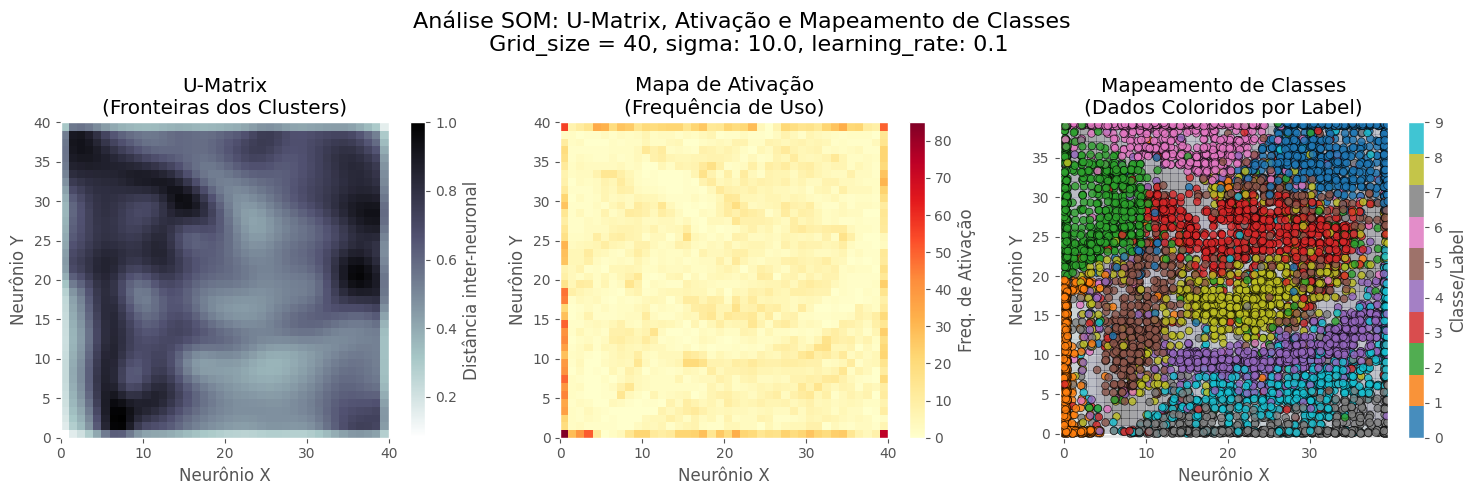

Gerando visualizações SOM com 10 classes distintas...


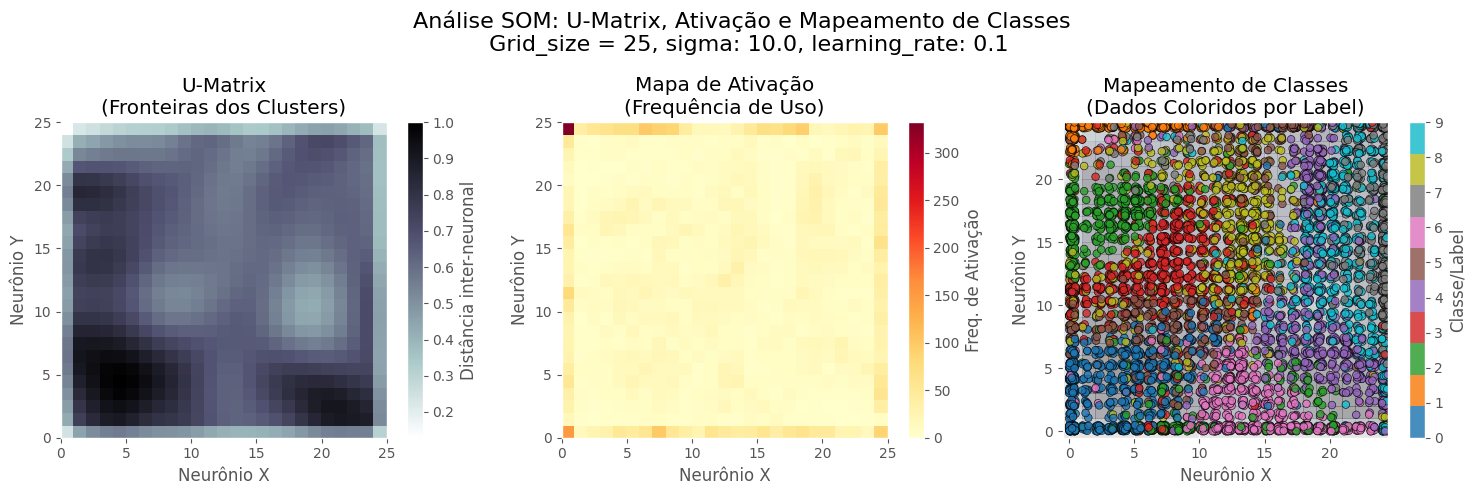

Gerando visualizações SOM com 10 classes distintas...


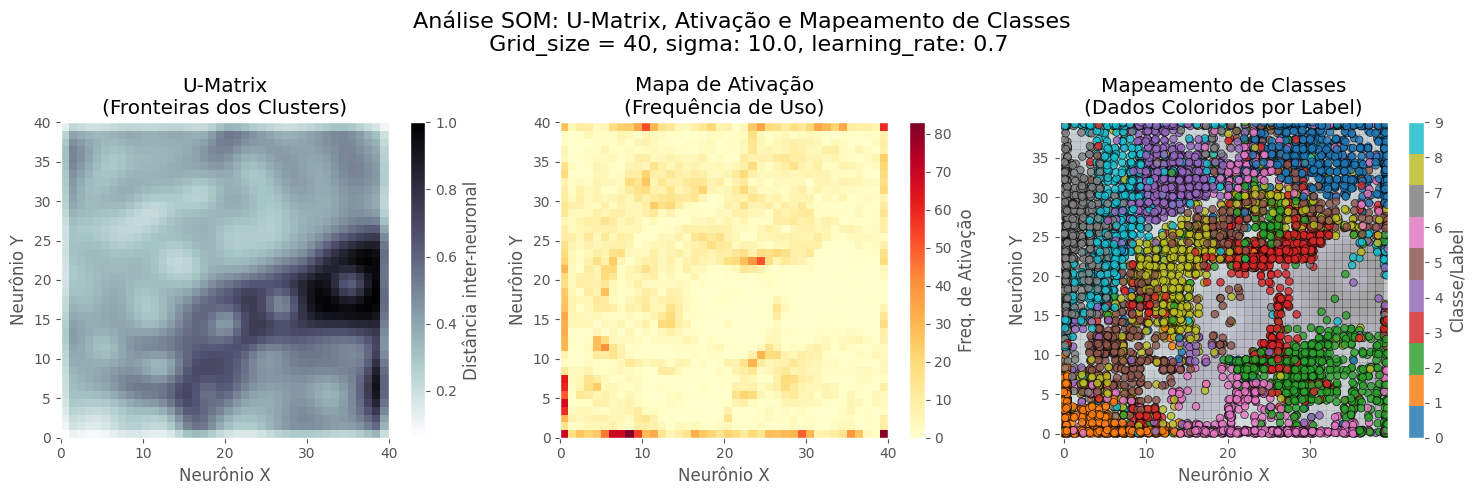

Gerando visualizações SOM com 10 classes distintas...


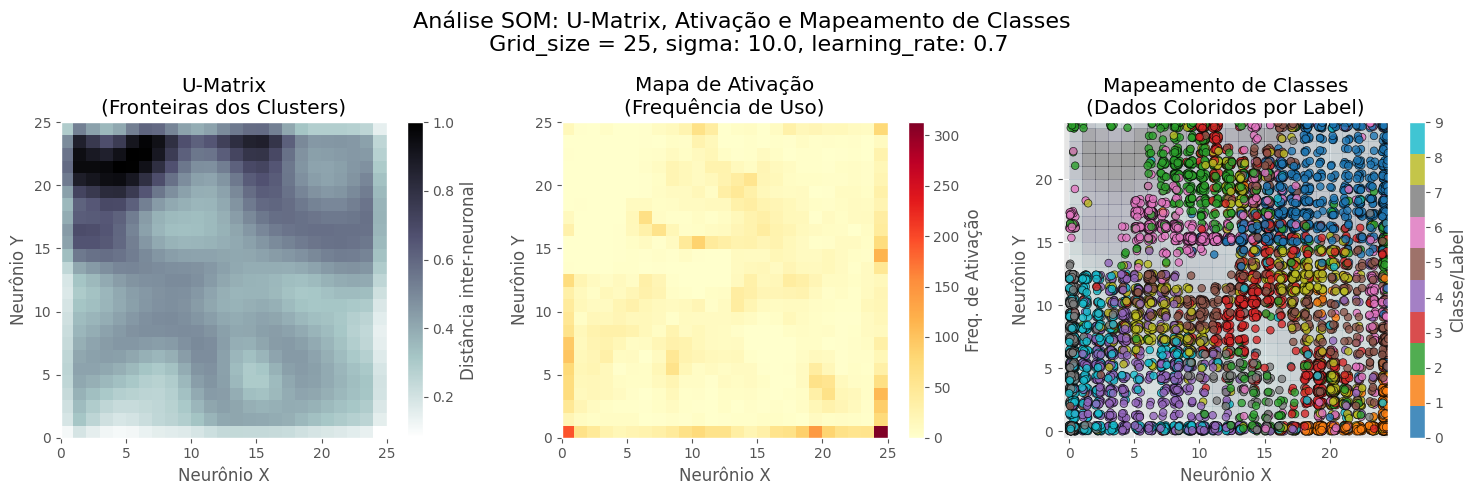

Gerando visualizações SOM com 10 classes distintas...


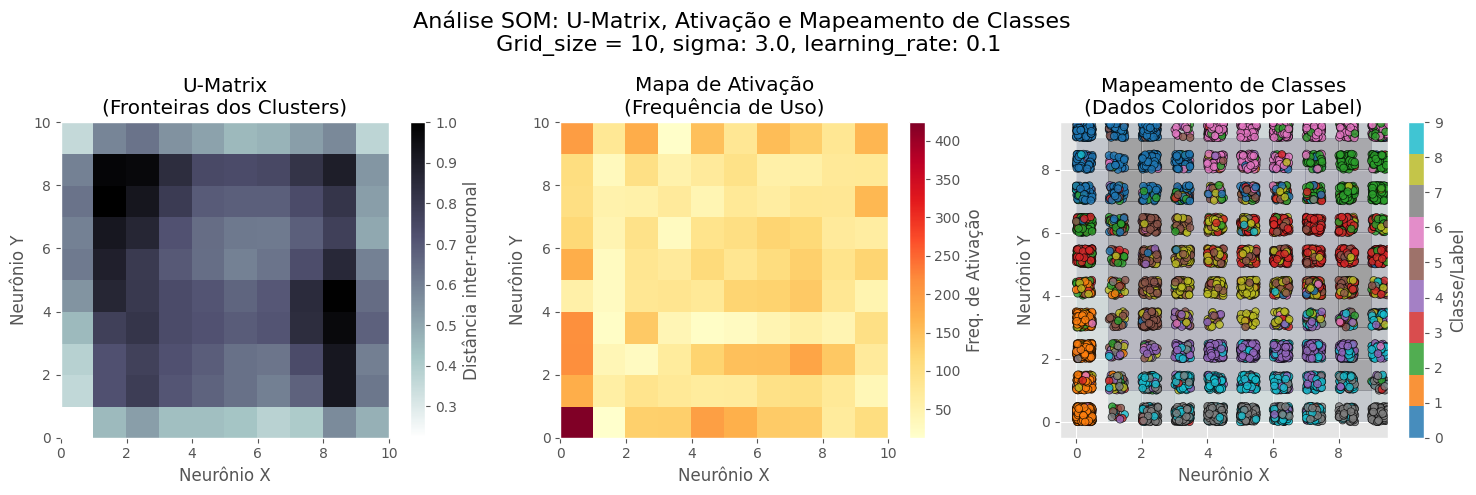

[<Figure size 1500x500 with 6 Axes>,
 <Figure size 1500x500 with 6 Axes>,
 <Figure size 1500x500 with 6 Axes>,
 <Figure size 1500x500 with 6 Axes>,
 <Figure size 1500x500 with 6 Axes>]

In [85]:
def get_best_experiments(results, top_n=5):
    df = pd.DataFrame(results)
    return df.sort_values(by=["top_error", "quantization error"], ascending=True).head(top_n)

def plot_som_analysis(som, X_scaled, labels, results, figsize=(15, 5)):
    """
    Plota três visualizações principais do SOM: U-Matrix, Mapa de Ativação e Mapeamento dos Labels.
    
    Parameters:
    -----------
    som : MiniSom object
        Objeto SOM já treinado
    X_scaled : array-like
        Dados de entrada escalados usados no treinamento
    labels : array-like
        Labels/classes dos dados para colorir os pontos
    figsize : tuple, default=(15, 5)
        Tamanho da figura (largura, altura)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Objeto da figura criada
    """
    
    print(f"Gerando visualizações SOM com {len(np.unique(labels))} classes distintas...")
    
    # Configurar estilo e figura
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'Análise SOM: U-Matrix, Ativação e Mapeamento de Classes \n '
                 f'Grid_size = {som.get_weights().shape[0]}, sigma: {results["sigma"]}, learning_rate: {results["learning_rate"]}', fontsize=16)

    # 1. U-Matrix (Matriz de Distâncias)
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('U-Matrix\n(Fronteiras dos Clusters)')
    u_matrix = som.distance_map().T
    im1 = ax1.pcolor(u_matrix, cmap='bone_r')
    fig.colorbar(im1, ax=ax1, label='Distância inter-neuronal')
    ax1.set_xlabel('Neurônio X')
    ax1.set_ylabel('Neurônio Y')
    
    # 2. Mapa de Ativação (Heatmap de Frequência)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('Mapa de Ativação\n(Frequência de Uso)')
    activation_map = som.activation_response(X_scaled).T
    im2 = ax2.pcolor(activation_map, cmap='YlOrRd')
    fig.colorbar(im2, ax=ax2, label='Freq. de Ativação')
    ax2.set_xlabel('Neurônio X')
    ax2.set_ylabel('Neurônio Y')
    
    # 3. Mapeamento dos Labels/Classes
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title('Mapeamento de Classes\n(Dados Coloridos por Label)')
    
    # Plotar a U-Matrix como fundo para dar contexto dos clusters
    ax3.pcolor(u_matrix, cmap='bone_r', alpha=0.3)
    
    # Obter coordenadas dos neurônios vencedores para cada amostra
    winner_coords = np.array([som.winner(x) for x in X_scaled]).T
    
    # Adicionar jitter para melhor visualização (evitar sobreposição)
    winner_coords_jittered = (
        winner_coords[0] + np.random.rand(len(X_scaled)) * 0.5,
        winner_coords[1] + np.random.rand(len(X_scaled)) * 0.5
    )
    
    # Plotar os pontos coloridos pelos labels
    scatter = ax3.scatter(winner_coords_jittered[0], winner_coords_jittered[1], 
                         c=labels, s=30, cmap='tab10', alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Adicionar colorbar
    cbar = fig.colorbar(scatter, ax=ax3, label='Classe/Label')
    
    # Se há poucas classes, criar legenda com nomes
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 10:
        # Criar legenda personalizada
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=plt.cm.tab10(i/len(unique_labels)), 
                               label=f'Classe {label}') 
                         for i, label in enumerate(unique_labels)]
        # ax3.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    ax3.set_xlabel('Neurônio X')
    ax3.set_ylabel('Neurônio Y')
    ax3.set_xlim(-0.5, som.get_weights().shape[0] - 0.5)
    ax3.set_ylim(-0.5, som.get_weights().shape[1] - 0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig



best_experiments = get_best_experiments(experiment_results, top_n=5)
print("Melhores experimentos:")
display(best_experiments)

# Printa os resultados dos melhores experimentos
[plot_som_analysis(row["som"], X_train, y_trained, row) for _, row in best_experiments.iterrows()]



## Implementing SOM using tensor flow

In [22]:
import tensorflow as tf
import numpy as np
from tqdm.autonotebook import tqdm

class SOMGPU:
    def __init__(self, m, n, dim, learning_rate=0.1, sigma=1.0):
        self.m = m
        self.n = n
        self.dim = dim
        self.learning_rate_initial = learning_rate
        self.sigma_initial = sigma
        
        # Otimização: Colocar tudo na GPU
        with tf.device('/GPU:0'):
            self.weights = tf.Variable(
                tf.random.normal([m * n, dim]), 
                trainable=True,
                dtype=tf.float32
            )
            self.locations = tf.constant(
                [[i, j] for i in range(m) for j in range(n)], 
                dtype=tf.float32
            )
    
    # O @tf.function é mais eficiente em operações maiores
    # @tf.function
    def update_weights_batch(self, batch_data, iteration, max_iterations):
        # 1. Encontrar o BMU para CADA amostra no lote
        # Forma do batch_data: (batch_size, dim)
        # Forma dos weights:   (m*n, dim)
        # Usamos broadcasting para calcular todas as distâncias de uma vez
        expanded_weights = tf.expand_dims(self.weights, axis=0) # (1, m*n, dim)
        expanded_batch = tf.expand_dims(batch_data, axis=1) # (batch_size, 1, dim)
        
        # Distâncias para cada amostra do lote para cada neurônio
        distances_sq = tf.reduce_sum(tf.square(expanded_weights - expanded_batch), axis=2) # (batch_size, m*n)
        bmu_indices = tf.argmin(distances_sq, axis=1) # (batch_size,)

        # 2. Atualizar pesos para CADA amostra no lote
        # Decaimento baseado na iteração global, não na época
        current_sigma = self.sigma_initial * tf.exp(-tf.cast(iteration, tf.float32) / max_iterations)
        current_lr = self.learning_rate_initial * tf.exp(-tf.cast(iteration, tf.float32) / max_iterations)
        
        bmu_locations = tf.gather(self.locations, bmu_indices) # (batch_size, 2)
        
        # Distância de todos os neurônios para cada BMU do lote
        # (1, m*n, 2) - (batch_size, 1, 2) -> (batch_size, m*n, 2)
        dist_to_bmu_sq = tf.reduce_sum(
            tf.square(tf.expand_dims(self.locations, 0) - tf.expand_dims(bmu_locations, 1)), axis=2
        )
        
        # Função de vizinhança para cada amostra do lote
        neighborhood = tf.exp(-dist_to_bmu_sq / (2 * tf.square(current_sigma))) # (batch_size, m*n)
        
        # Cálculo do delta (mudança nos pesos)
        # (batch_size, m*n, 1) * ((batch_size, 1, dim) - (1, m*n, dim))
        delta_numerator = tf.expand_dims(neighborhood, axis=2) * (expanded_batch - expanded_weights)
        
        # Média dos deltas em todo o lote
        delta = tf.reduce_mean(delta_numerator, axis=0) * current_lr
        
        # Aplica a atualização
        self.weights.assign_add(delta)

    def train(self, data, epochs, batch_size=32):
        # Usar tf.data.Dataset é muito mais eficiente para lidar com dados
        dataset = tf.data.Dataset.from_tensor_slices(data.astype(np.float32))
        dataset = dataset.shuffle(buffer_size=len(data)).batch(batch_size)
        
        max_iterations = epochs * len(list(dataset))
        
        for epoch in tqdm(range(epochs), desc="Epochs"):
            for i, batch in enumerate(dataset):
                iteration = epoch * len(list(dataset)) + i
                self.update_weights_batch(batch, iteration, max_iterations)

    def map_vects(self, data):
        """ Retorna as coordenadas 2D para cada vetor de entrada """
        data_tf = tf.constant(data, dtype=tf.float32)
        
        expanded_weights = tf.expand_dims(self.weights, axis=0)
        expanded_data = tf.expand_dims(data_tf, axis=1)
        
        distances_sq = tf.reduce_sum(tf.square(expanded_weights - expanded_data), axis=2)
        bmu_indices = tf.argmin(distances_sq, axis=1)
        
        coords = tf.gather(self.locations, bmu_indices)
        return coords.numpy()

In [23]:
som_gpu = SOMGPU(m=7, n=7, dim=X_mnist.shape[1], learning_rate=0.5, sigma=5.0)
som_gpu.train(X_mnist, epochs=10, batch_size=32)  # Treinando o SOM na GPU

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2025-10-15 17:27:23.420293: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
